In [1]:
from src.functions import *

# Global setting
with open(projectdir+'setting.json', 'r') as f:
    setting = json.load(f)
    _gamma = setting["gamma"]
    _T = setting["T"]
    _t = setting["t"]
    _num_random_models = setting["num_random_models"]

# Load the JSON file
with open(projectdir+'instances.json', 'r') as f:
    instances = json.load(f)

In [2]:
n = 4

In [3]:
gamma_lims = (0,1) 
gamma_steps = 48
T_lims = (1e-2,1e2)
T_steps = 48

gamma_range = np.linspace(gamma_lims[0], gamma_lims[1], gamma_steps)
T_range = np.geomspace(T_lims[0], T_lims[1], T_steps)

In [4]:
def f_mag(T):
    mag = np.zeros((gamma_steps, _num_random_models))
    for gamma_id, gamma in enumerate(gamma_range):
        for i, instance in enumerate(instances[f'{n}']):
            m = IsingModel.from_coefficients(n, instance)
            H_ising = np.diag(m.E_rescaled)
            H_mixer = H_mixer_list[m.n-1]
            H = (1-gamma)*H_ising + gamma*H_mixer
            mag[gamma_id, i] = magnetization(H, T)
    return mag

def f_qea(T):
    q = np.zeros((gamma_steps, _num_random_models))
    for gamma_id, gamma in enumerate(gamma_range):
        for i, instance in enumerate(instances[f'{n}']):
            m = IsingModel.from_coefficients(n, instance)
            H_ising = np.diag(m.E_rescaled)
            H_mixer = H_mixer_list[m.n-1]
            H = (1-gamma)*H_ising + gamma*H_mixer
            q[gamma_id, i] = qea(H, T)
    return q

In [5]:
sweep_data = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(f_qea)(t) for t in tqdm(T_range)))

  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [00:00<00:00, 109.20it/s]

100%|██████████| 48/48 [00:00<00:00, 96.77it/s] 

In [6]:
q = np.abs(sweep_data)
q_avg = np.mean(q, axis=2)
q_std = np.std(q, axis=2, ddof=1)

# Save the data

In [7]:
grid_search = {'q': q.tolist(),
               'q_avg': q_avg.tolist(),
               'q_std': q_std.tolist(),
               'num_random_models': _num_random_models,
               'gamma_range': gamma_range.tolist(),
               'T_range': T_range.tolist(),
               'n': n}

save_in_json(grid_search, f'data/phase_diagram_n{n}.json')

# Plot the results

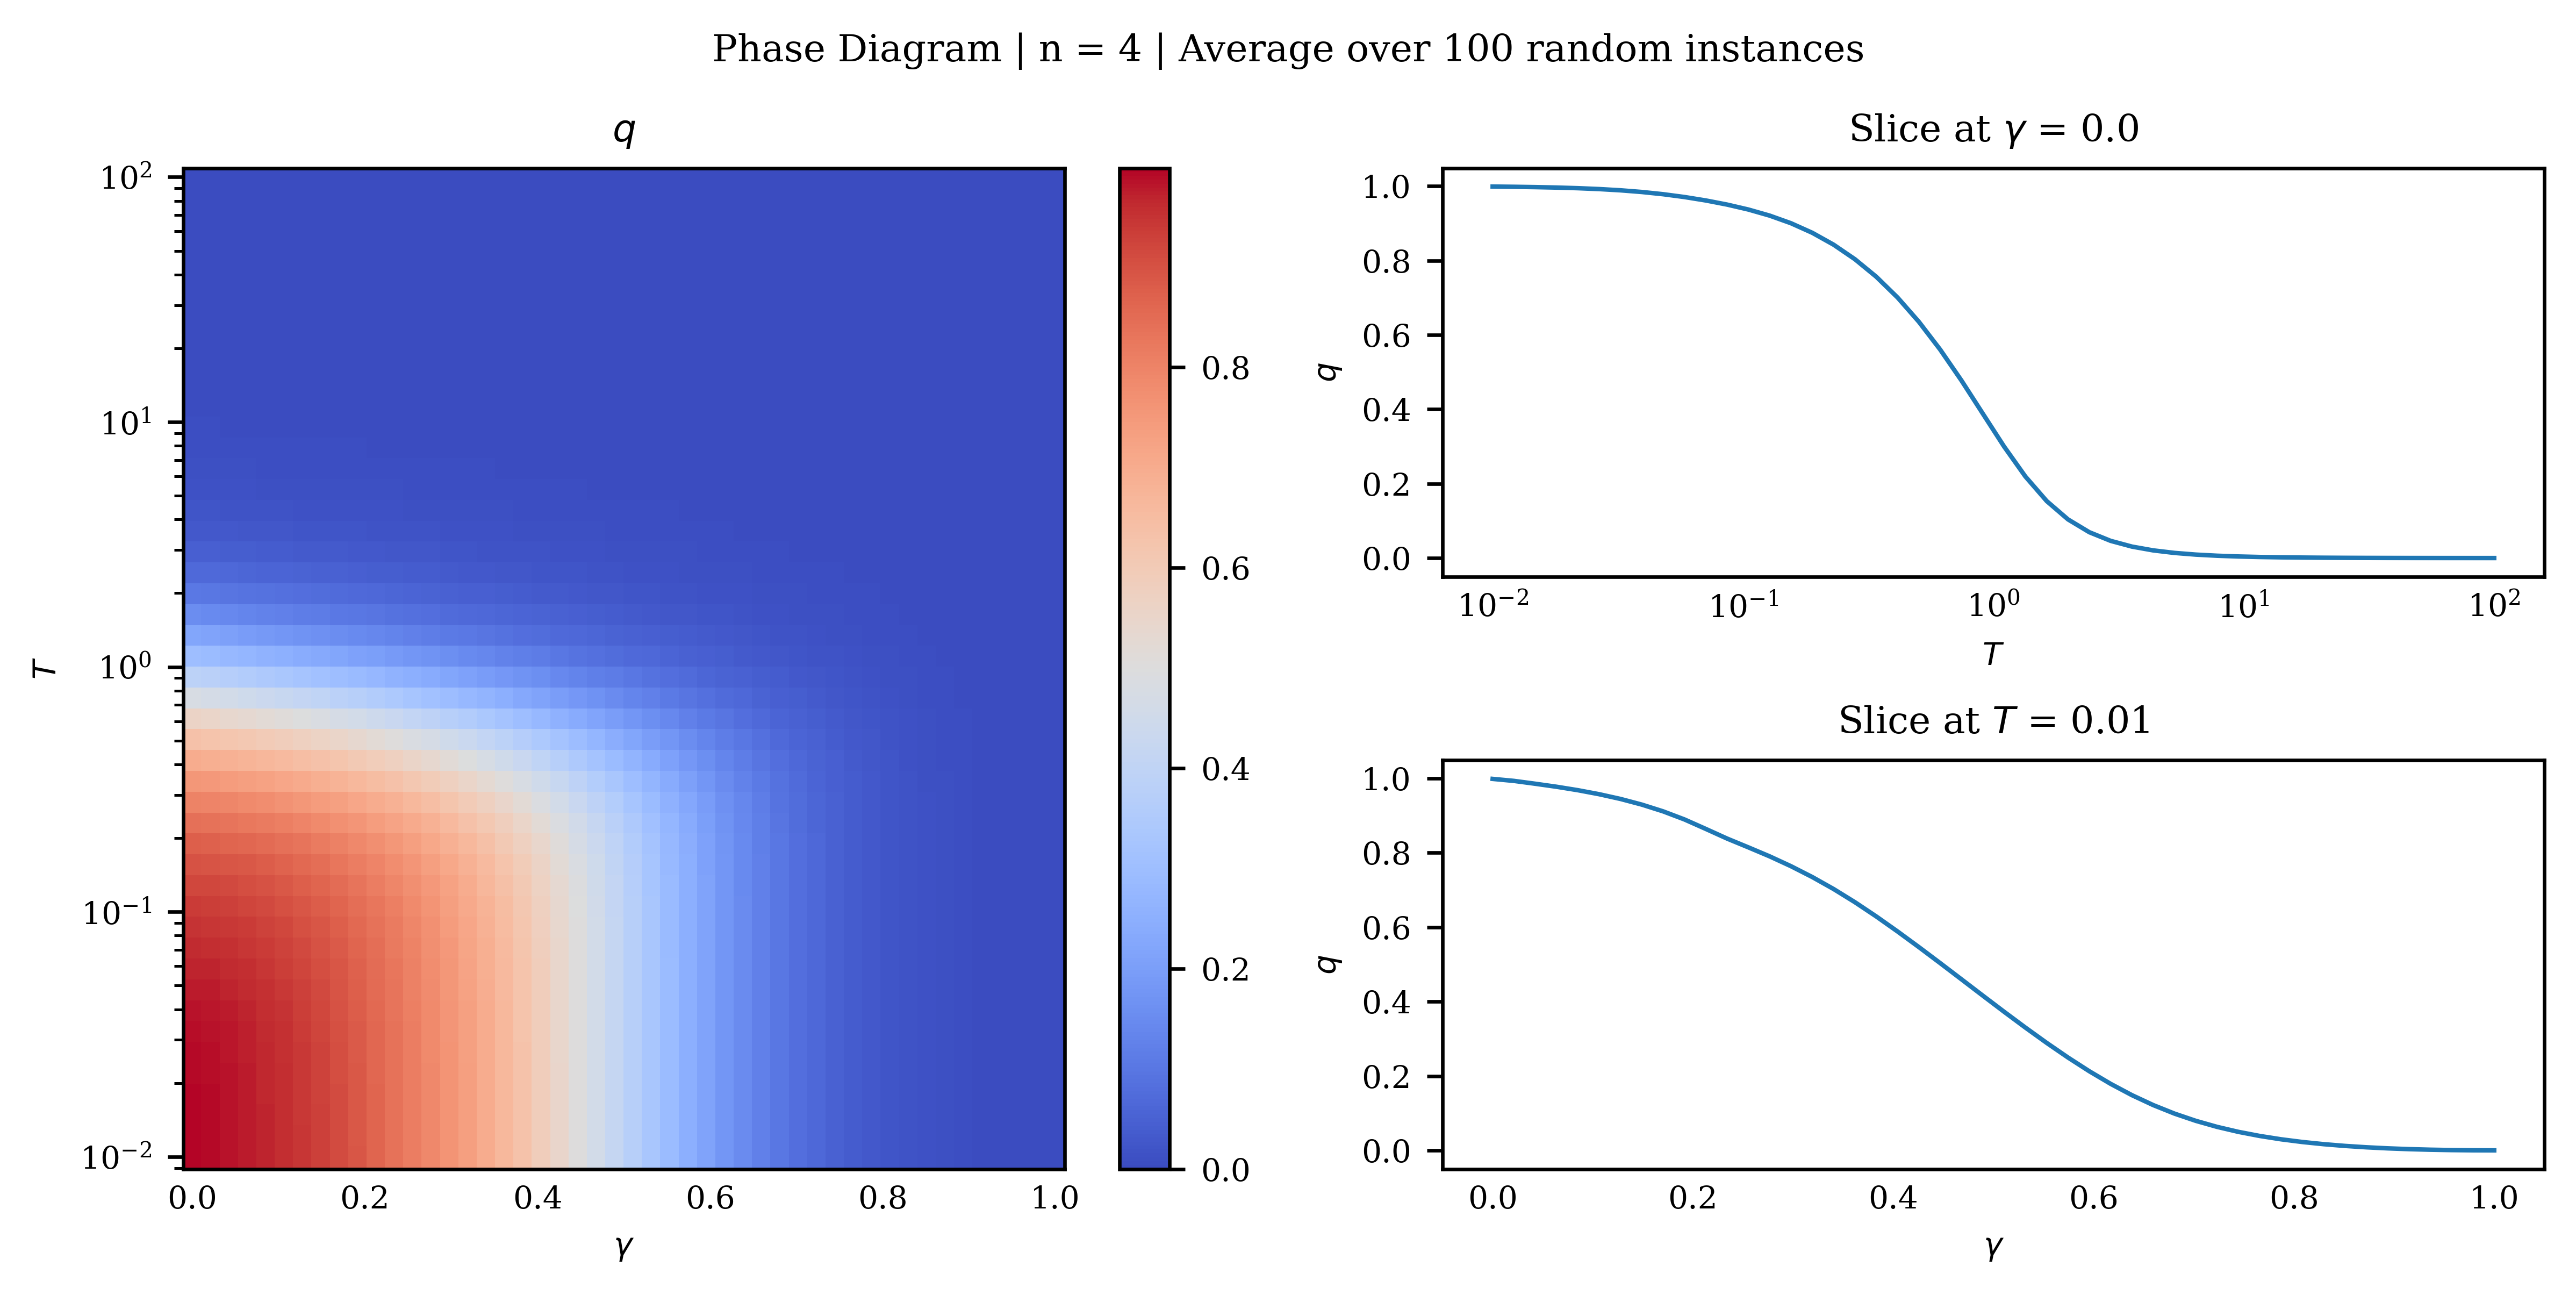

In [8]:
fig, axs = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              figsize=(8, 4),
                              width_ratios=[2,2])
fig.suptitle(f'Phase Diagram | n = {n} | Average over {_num_random_models} random instances')

pc = axs['left'].pcolor(gamma_range, 
                        T_range, 
                        q_avg,
                        cmap='coolwarm')
fig.colorbar(pc, ax=axs['left'])
axs['left'].set_xlabel('$\gamma$')
axs['left'].set_ylabel('$T$')
axs['left'].set_yscale('log')
axs['left'].set_title('$q$')

axs['upper right'].plot(T_range, q_avg[:,0])
axs['upper right'].set_xlabel('$T$')
axs['upper right'].set_xscale('log')
axs['upper right'].set_ylabel('$q$')
axs['upper right'].set_title(f'Slice at $\gamma$ = {gamma_range[0]}')

axs['lower right'].plot(gamma_range, q_avg[1,:])
axs['lower right'].set_xlabel('$\gamma$')
axs['lower right'].set_ylabel('$q$')
axs['lower right'].set_title(f'Slice at $T$ = {T_range[1].round(2)}')

fig.tight_layout()